In [1]:
# installing pytorch lightning and transformer
! pip install --quiet lightning
! pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 24.6 MB/s eta 0:00:00


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5151/Group project'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5151/Group project
/content/gdrive/My Drive/BT5151/Group project


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# importing all necessary packages
from os import listdir
from os.path import join
from sklearn.model_selection import train_test_split
import string
from torch.utils.data import Dataset, DataLoader
import torch
import torchmetrics
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [6]:
unseen_df = pd.read_csv('unseen_reviews.csv')

In [7]:
unseen_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time_ymd
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
1,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21
2,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012-07-12
3,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,2012-06-20
4,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,2012-05-03
...,...,...,...,...,...,...,...,...,...,...
198654,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,Mixed wrong,I had ordered some of these a few months back ...,2012-02-11
198655,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09
198656,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21
198657,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13


In [ ]:
# Fill those summary with 'NA' values with an empty space
unseen_df['Summary'].fillna('', inplace=True)

In [8]:
# Converting columns to string type
unseen_df.Text=unseen_df.Text.apply(str)
unseen_df.Summary=unseen_df.Summary.apply(str)

# Combine 'Summary' and 'Text'
unseen_df['Summary_Text']=unseen_df[['Summary','Text']].agg(' '.join, axis=1)
unseen_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time_ymd,Summary_Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Not as Advertised Product arrived labeled as J...
1,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Great taffy Great taffy at a great price. The...
2,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012-07-12,Nice Taffy I got a wild hair for taffy and ord...
3,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,2012-06-20,Great! Just as good as the expensive brands! ...
4,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,2012-05-03,"Wonderful, tasty taffy This taffy is so good. ..."
...,...,...,...,...,...,...,...,...,...,...,...
198654,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,Mixed wrong,I had ordered some of these a few months back ...,2012-02-11,Mixed wrong I had ordered some of these a few ...
198655,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,disappointed I'm disappointed with the flavor....
198656,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,Perfect for our maltipoo These stars are small...
198657,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,Favorite Training and reward treat These are t...


In [9]:
# Check the number of duplicate records by grouping the data on UserId and ProductId
unseen_df[unseen_df.duplicated(['UserId','ProductId'])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time_ymd,Summary_Text
177,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,"pretty good, could be better",Glad to find these in a one ounce size but the...,2012-04-10,"pretty good, could be better Glad to find thes..."
180,430,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0,0,5,Kettle potato chips: Sweet onion,WOW! I have eaten quite a few potato chips in...,2012-03-07,Kettle potato chips: Sweet onion WOW! I have...
186,436,B000G6RYNE,A15USNEAJUXOSH,L. Schrank,0,0,5,Delicious,"I love these chips, I buy the 24 pack once a m...",2012-01-09,"Delicious I love these chips, I buy the 24 pac..."
189,504,B000G6RYNE,A2OEUROGZDTXUJ,J. Graves,1,2,4,I like them.,"Amazon's suggestion for a 4 star review is ""I ...",2012-01-31,I like them. Amazon's suggestion for a 4 star ...
209,588,B000G6RYNE,A2OEUROGZDTXUJ,J. Graves,1,1,5,My favorite Kettle Chip,"These are my favorite, but they aren't for eve...",2012-01-31,"My favorite Kettle Chip These are my favorite,..."
...,...,...,...,...,...,...,...,...,...,...,...
198381,567744,B005K4Q68Q,A1CYKFUPE5ZGBA,"Mike G ""Mike G""",0,0,5,"Great Deal, Great Cocoa!",Got a brand new Keurig machine for Christmas a...,2012-01-11,"Great Deal, Great Cocoa! Got a brand new Keuri..."
198429,567869,B005K4Q68Q,ALD467ZEFBPDF,"DenDen ""Dennis""",1,1,5,GREAT Cocoa for the price.,"Lets face it, $11 isn't going to get you the m...",2012-02-20,"GREAT Cocoa for the price. Lets face it, $11 i..."
198471,567988,B0030VJ8YU,AOWHV1P78VYG0,CC,6,6,1,"Used to be great, company changed the formula","Why, why, why did they change the formula?? O...",2012-03-04,"Used to be great, company changed the formula ..."
198487,568027,B0030VJ8YU,A1UFPQ3C1MI3QC,Kate Wolf,1,1,5,Love it!!!,Love this product! Our daughter couldn't have ...,2012-01-15,Love it!!! Love this product! Our daughter cou...


In [10]:
# Droppping duplicate records and keeping the latest one per group
unseen_df=unseen_df.drop_duplicates(subset=['UserId','ProductId'], keep='last', inplace=False)
unseen_df.reset_index(drop=True, inplace=True)
# Check if the duplicates are still there
unseen_df[unseen_df.duplicated(['UserId','ProductId'])].count()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Summary                   0
Text                      0
Time_ymd                  0
Summary_Text              0
dtype: int64

In [11]:
def score_classification(score):

    if score > 3:
        return 1
    elif score == 3:
        return 0
    else:
        return -1


In [12]:
# Classify the reviews based on 'Score'
unseen_df.loc[:, 'Sentiment'] = unseen_df['Score'].apply(score_classification)
unseen_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time_ymd,Summary_Text,Sentiment
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Not as Advertised Product arrived labeled as J...,-1
1,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Great taffy Great taffy at a great price. The...,1
2,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012-07-12,Nice Taffy I got a wild hair for taffy and ord...,1
3,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,2012-06-20,Great! Just as good as the expensive brands! ...,1
4,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,2012-05-03,"Wonderful, tasty taffy This taffy is so good. ...",1


In [13]:
unseen = unseen_df[['ProductId','Summary_Text', 'Sentiment']].copy()

In [14]:
unseen

,ProductId,Summary_Text,Sentiment
0,B00813GRG4,Not as Advertised Product arrived labeled as J...,-1
1,B006K2ZZ7K,Great taffy Great taffy at a great price. The...,1
2,B006K2ZZ7K,Nice Taffy I got a wild hair for taffy and ord...,1
3,B006K2ZZ7K,Great! Just as good as the expensive brands! ...,1
4,B006K2ZZ7K,"Wonderful, tasty taffy This taffy is so good. ...",1
...,...,...,...
197486,B001EO7N10,Mixed wrong I had ordered some of these a few ...,-1
197487,B003S1WTCU,disappointed I'm disappointed with the flavor....,-1
197488,B004I613EE,Perfect for our maltipoo These stars are small...,1
197489,B004I613EE,Favorite Training and reward treat These are t...,1


In [15]:
unseen.to_csv('unseen.csv',index=False)

In [33]:
unseen['ProductId'].value_counts()

ProductId
B007JFMH8M    913
B006MONQMC    491
B002IEZJMA    483
B002IEVJRY    483
B007Y59HVM    479
             ... 
B004CHB786      1
B004GZ6K04      1
B001IJDKG8      1
B002QBXS50      1
B001LR2CU2      1
Name: count, Length: 48381, dtype: int64

In [73]:
top_product_1 = unseen[unseen['ProductId'] == 'B007JFMH8M'].copy()

top_product_1

,ProductId,Summary_Text,Sentiment
194961,B007JFMH8M,Delicious! I love these cookies! Not only are...,1
194962,B007JFMH8M,Great Anytime of Day! Quaker Soft Baked Oatmea...,1
194963,B007JFMH8M,Very good! I am usually not a huge fan of oatm...,1
194964,B007JFMH8M,Quaker Oats Oatmeal Raisin Mom Voxbox Review C...,1
194965,B007JFMH8M,"Quick, simple HEALTHY snack for the kiddos!!! ...",1
...,...,...,...
195869,B007JFMH8M,Yummy! I loved these cookies and so did my kid...,1
195870,B007JFMH8M,Quaker Soft Baked Cookies This is a great tast...,1
195871,B007JFMH8M,Delicious! These are great for a quick snack! ...,1
195872,B007JFMH8M,yummy I love the Quaker soft baked cookies. T...,1


In [74]:
top_product_2 = unseen[unseen['ProductId'] == 'B006MONQMC'].copy()

top_product_2

,ProductId,Summary_Text,Sentiment
187879,B006MONQMC,Light and flavorful; helps me drink more water...,1
187880,B006MONQMC,Wasn't bad I am a really big fan of these sque...,0
187881,B006MONQMC,Great vitamin/mineral additive I'm not a water...,1
187882,B006MONQMC,"How much is a ""squeeze""? This vitamin/caffeine...",-1
187883,B006MONQMC,So-so water additive I'm all for products that...,0
...,...,...,...
188365,B006MONQMC,"For active adults, better choice than Mio This...",1
188366,B006MONQMC,Tastes good and works also with milk...I'm sol...,1
188367,B006MONQMC,Yuck!!! Qustionable benefits and tough to disp...,-1
188368,B006MONQMC,It's got electrolytes Or so the bottle wrappin...,-1


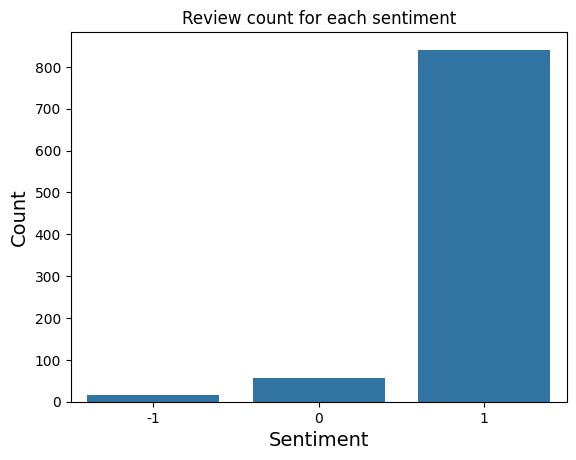

In [75]:
sns.countplot(x='Sentiment', data=top_product_1);
plt.xlabel('Sentiment',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review count for each sentiment');

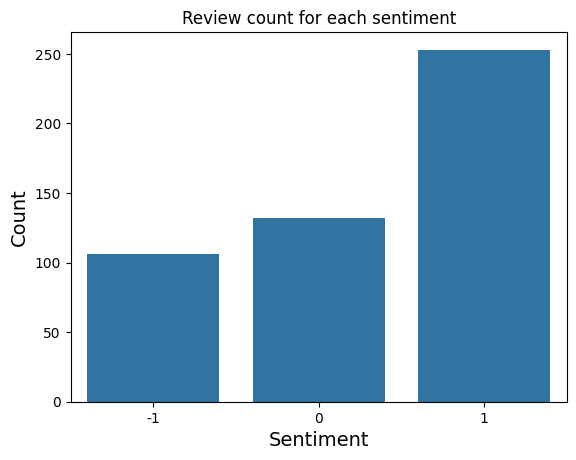

In [76]:
sns.countplot(x='Sentiment', data=top_product_2);
plt.xlabel('Sentiment',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review count for each sentiment');

# Sentiment Prediction using Best Model (Multi-Head Attention)

In [16]:
%run tokenizer_class.py
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
from tokenizer_class import tokenize_text_with_labels
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [18]:
reviews_df = pd.read_csv('reviews_df.csv')

In [19]:
sentences = reviews_df['Summary_Text']
# from keras.utils import to_categorical
labels = reviews_df['Sentiment']

# Adjust labels to start from 0
labels_adjusted = labels + 1

# Convert adjusted labels to categorical format
categorical_labels = to_categorical(labels_adjusted)

In [20]:
#Train-test-split
X_train, X_val, y_train, y_val = train_test_split(sentences, categorical_labels, test_size=0.2, stratify= categorical_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [21]:
X_test

78110     Berry Energy Tea is loaded with vitamins but h...
43339     Love the taste!  Stats on the content percenta...
21416     Interestingly delicious Since I usually eat th...
116944    My dog LOVES'EM!!  Fist time w/this brand So f...
67715     Any good alternatives to Verona? I have been b...
                                ...                        
72389     not sure about the cost, but like the BIG jars...
42877     Green & Black's organic hot chocolate drink ha...
74740     Not Tasty for my Dog These days it is not easy...
37213     Ener_G Baking Powder (Sodium Free This product...
41666     It was okay... When I first received the hot s...
Name: Summary_Text, Length: 16160, dtype: object

In [77]:
test_1_col = top_product_1['Summary_Text']
test_1_col

194961    Delicious! I love these cookies!  Not only are...
194962    Great Anytime of Day! Quaker Soft Baked Oatmea...
194963    Very good! I am usually not a huge fan of oatm...
194964    Quaker Oats Oatmeal Raisin Mom Voxbox Review C...
194965    Quick, simple HEALTHY snack for the kiddos!!! ...
                                ...                        
195869    Yummy! I loved these cookies and so did my kid...
195870    Quaker Soft Baked Cookies This is a great tast...
195871    Delicious! These are great for a quick snack! ...
195872    yummy I love the Quaker soft baked cookies.  T...
195873    Quaker Soft Baked Cookie This cookie is really...
Name: Summary_Text, Length: 913, dtype: object

In [78]:
test_2_col = top_product_2['Summary_Text']
test_2_col

187879    Light and flavorful; helps me drink more water...
187880    Wasn't bad I am a really big fan of these sque...
187881    Great vitamin/mineral additive I'm not a water...
187882    How much is a "squeeze"? This vitamin/caffeine...
187883    So-so water additive I'm all for products that...
                                ...                        
188365    For active adults, better choice than Mio This...
188366    Tastes good and works also with milk...I'm sol...
188367    Yuck!!! Qustionable benefits and tough to disp...
188368    It's got electrolytes Or so the bottle wrappin...
188369    Tasty...vitamins aside, it's making me drink m...
Name: Summary_Text, Length: 491, dtype: object

In [81]:
test__1_labels_ = top_product_1['Sentiment']

# Adjust labels to start from 0
test__1_labels_adjusted = test__1_labels_ + 1

# Convert adjusted labels to categorical format
categorical_test_1_labels = to_categorical(test__1_labels_adjusted)

In [82]:
test__2_labels_ = top_product_2['Sentiment']

# Adjust labels to start from 0
test__2_labels_adjusted = test__2_labels_ + 1

# Convert adjusted labels to categorical format
categorical_test_2_labels = to_categorical(test__2_labels_adjusted)

In [83]:
# Tokenization
max_len = 562
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

test_1_sequences = tokenizer.texts_to_sequences(test_1_col)
test_1_col = pad_sequences(test_1_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


test_2_sequences = tokenizer.texts_to_sequences(test_2_col)
test_2_col = pad_sequences(test_2_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# Define the TokenAndPositionEmbedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Load the saved model
best_model = load_model("/content/gdrive/My Drive/BT5151/Group project/best_model.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerEncoder": TransformerEncoder})


In [102]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay

y_test_labels = np.argmax(categorical_test_1_labels, axis=1)
y_pred = best_model.predict(test_1_col)
y_pred_classes = np.argmax(y_pred, axis=1)
top_product_1['Predictions'] = y_pred_classes - 1

precision = precision_score(y_test_labels, y_pred_classes,average='weighted')
print('Precision: {:.2f}%'.format(precision))
recall = recall_score(y_test_labels, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format( recall))
f1 = f1_score(y_test_labels, y_pred_classes,average='weighted')
print('F1_score: {:.2f}%'.format(f1))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test_labels,y_pred_classes))

29/29 [==============================] - 27s 948ms/step
Precision: 0.92%
Recall: 0.93%
F1_score: 0.92%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.29      0.44      0.35        16
           1       0.47      0.25      0.33        56
           2       0.96      0.98      0.97       841

    accuracy                           0.93       913
   macro avg       0.57      0.56      0.55       913
weighted avg       0.92      0.93      0.92       913



In [104]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay

y_test_labels = np.argmax(categorical_test_2_labels, axis=1)
y_pred = best_model.predict(test_2_col)
y_pred_classes = np.argmax(y_pred, axis=1)
top_product_2['Predictions'] = y_pred_classes - 1

precision = precision_score(y_test_labels, y_pred_classes,average='weighted')
print('Precision: {:.2f}%'.format(precision))
recall = recall_score(y_test_labels, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format( recall))
f1 = f1_score(y_test_labels, y_pred_classes,average='weighted')
print('F1_score: {:.2f}%'.format(f1))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test_labels,y_pred_classes))

16/16 [==============================] - 11s 718ms/step
Precision: 0.67%
Recall: 0.66%
F1_score: 0.66%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.65      0.50      0.56       106
           1       0.48      0.60      0.54       132
           2       0.77      0.75      0.76       253

    accuracy                           0.66       491
   macro avg       0.63      0.62      0.62       491
weighted avg       0.67      0.66      0.66       491



In [103]:
top_product_1

,ProductId,Summary_Text,Sentiment,Predictions
194961,B007JFMH8M,Delicious! I love these cookies! Not only are...,1,1
194962,B007JFMH8M,Great Anytime of Day! Quaker Soft Baked Oatmea...,1,1
194963,B007JFMH8M,Very good! I am usually not a huge fan of oatm...,1,1
194964,B007JFMH8M,Quaker Oats Oatmeal Raisin Mom Voxbox Review C...,1,1
194965,B007JFMH8M,"Quick, simple HEALTHY snack for the kiddos!!! ...",1,1
...,...,...,...,...
195869,B007JFMH8M,Yummy! I loved these cookies and so did my kid...,1,1
195870,B007JFMH8M,Quaker Soft Baked Cookies This is a great tast...,1,1
195871,B007JFMH8M,Delicious! These are great for a quick snack! ...,1,1
195872,B007JFMH8M,yummy I love the Quaker soft baked cookies. T...,1,1


In [119]:
top_product_1.to_csv('top_product_1.csv',index=False)
top_product_2.to_csv('top_product_2.csv',index=False)

In [4]:
top_product_1 = pd.read_csv('top_product_1.csv')
top_product_2 = pd.read_csv('top_product_2.csv')

# Spacy Aspect Classifier

In [5]:
import re
import spacy
import tqdm
from tqdm import tqdm
!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 891.2 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Top Product 1 - Oatmeal Cookie

In [7]:
aspect_terms = []

oatmeal_cookie = top_product_1.reset_index(drop=True)  # Resetting index

for i in range(len(oatmeal_cookie['Summary_Text'])):
    amod_pairs = []
    advmod_pairs = []
    compound_pairs = []
    xcomp_pairs = []
    neg_pairs = []
    # Assuming doc is defined somewhere
    doc = nlp(oatmeal_cookie.loc[i, 'Summary_Text'])
    for token in doc:
        if token.pos_ == 'NOUN':
            for j in token.lefts:
                if j.dep_ == 'compound':
                    compound_pairs.append((j.text+' '+token.text, token.text))
                if j.dep_ == 'amod' and j.pos_ == 'ADJ':   # primary condition
                    str1 = j.text+' '+token.text
                    amod_pairs.append(j.text+' '+token.text)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':  # secondary condition to get adjective of adjectives
                            str2 = k.text+' '+j.text+' '+token.text
                            amod_pairs.append(k.text+' '+j.text+' '+token.text)
                            mtch = re.search(re.escape(str1), re.escape(str2))
                            if mtch is not None:
                                amod_pairs.remove(str1)
        elif token.pos_ == 'VERB':
            for j in token.lefts:
                if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                    advmod_pairs.append(j.text+' '+token.text)
                if j.dep_ == 'neg' and j.pos_ == 'ADV':
                    neg_pairs.append(j.text+' '+token.text)
            for j in token.rights:
                if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                    advmod_pairs.append(token.text+' '+j.text)
        elif token.pos_ == 'ADJ':
            for j, h in zip(token.rights, token.lefts):
                for j, h in zip(token.rights, token.lefts):
                    if j.dep_ == 'xcomp' and h.dep_ != 'neg':
                        for k in j.lefts:
                            if k.dep_ == 'aux':
                                xcomp_pairs.append(token.text+' '+k.text+' '+j.text)
                    elif j.dep_ == 'xcomp' and h.dep_ == 'neg':
                        if k.dep_ == 'aux':
                            neg_pairs.append(h.text+' '+token.text+' '+k.text+' '+j.text)

    pairs = list(set(amod_pairs + advmod_pairs + neg_pairs + xcomp_pairs))
    for i in range(len(pairs)):
      if len(compound_pairs) != 0:
            for comp in compound_pairs:
              mtch = re.search(re.escape(comp[1]), re.escape(pairs[i]))
              if mtch is not None:
                  pairs[i] = pairs[i].replace(mtch.group(), comp[0])

    aspect_terms.append(pairs)


oatmeal_cookie['aspect_terms'] = aspect_terms


In [8]:
oatmeal_cookie['aspect_terms']

0                                       [definitely add]
1      [right amount, snack later, great taste, large...
2      [definitely recommend, huge fan, probably pick...
3      [first love, high quality, nice portion, Soft ...
4      [healthy HEALTHY snack, pleased to give, simpl...
                             ...                        
908    [read here, full review, favorite part, so did...
909    [great tasting cookie, usually like, just made...
910    [quick snack, sweet tooth, whole grain, even h...
911    [other flavors, soft cookies, baked cookies, o...
912                                         [works well]
Name: aspect_terms, Length: 913, dtype: object

In [9]:
oatmeal_KPC = ['taste', 'packaging', 'price', 'delivery','quality','health','texture','portion']

In [10]:
class EmbeddingClassifier:
    """Classifying aspect terms into aspects using word embedding similarity"""

    def __init__(self, nlp, classes:list, threshold:int=0.4):
        self.classes = classes
        self.class_spans = [nlp(item)[:] for item in classes]
        self.threshold = threshold
        self.nlp = nlp

    def predict(self, items:list):
        """Match items to classes using embeddings"""
        predicted_classes = set()

        for item in items:
            class_similarities = [
                nlp(item)[:].similarity(class_item)
                for class_item in self.class_spans
            ]
            max_idx = np.argmax(class_similarities)
            if class_similarities[max_idx] > self.threshold:
                predicted_classes.add(self.classes[max_idx])

        return list(predicted_classes)

In [16]:
oatmeal_cookie_clf = EmbeddingClassifier(nlp=nlp, classes=oatmeal_KPC, threshold=0.35)

In [17]:
oatmeal_cookie['aspect'] = oatmeal_cookie['aspect_terms'].apply(lambda x: oatmeal_cookie_clf.predict(x))

In [18]:
oatmeal_cookie

,ProductId,Summary_Text,Sentiment,Predictions,aspect_terms,aspect
0,B007JFMH8M,Delicious! I love these cookies! Not only are...,1,1,[definitely add],[texture]
1,B007JFMH8M,Great Anytime of Day! Quaker Soft Baked Oatmea...,1,1,"[right amount, snack later, great taste, large...","[delivery, portion, texture, taste, packaging]"
2,B007JFMH8M,Very good! I am usually not a huge fan of oatm...,1,1,"[definitely recommend, huge fan, probably pick...","[packaging, texture, delivery]"
3,B007JFMH8M,Quaker Oats Oatmeal Raisin Mom Voxbox Review C...,1,1,"[first love, high quality, nice portion, Soft ...","[quality, portion]"
4,B007JFMH8M,"Quick, simple HEALTHY snack for the kiddos!!! ...",1,1,"[healthy HEALTHY snack, pleased to give, simpl...","[taste, delivery]"
...,...,...,...,...,...,...
908,B007JFMH8M,Yummy! I loved these cookies and so did my kid...,1,1,"[read here, full review, favorite part, so did...","[taste, delivery, portion]"
909,B007JFMH8M,Quaker Soft Baked Cookies This is a great tast...,1,1,"[great tasting cookie, usually like, just made...","[taste, texture, packaging]"
910,B007JFMH8M,Delicious! These are great for a quick snack! ...,1,1,"[quick snack, sweet tooth, whole grain, even h...","[taste, texture, quality]"
911,B007JFMH8M,yummy I love the Quaker soft baked cookies. T...,1,1,"[other flavors, soft cookies, baked cookies, o...","[taste, texture]"


In [20]:
num_aspects_counts = oatmeal_cookie['aspect'].apply(len).value_counts().sort_index()

print("Number of Aspects Counts:")
print(num_aspects_counts)

Number of Aspects Counts:
aspect
0     91
1    237
2    277
3    173
4     75
5     41
6     17
7      2
Name: count, dtype: int64


In [50]:
exploded_df = oatmeal_cookie.explode('aspect')
aspect_sentiment_counts = exploded_df.groupby(['aspect', 'Predictions']).size().reset_index(name='Count')
pivoted_df = aspect_sentiment_counts.pivot(index='aspect', columns='Predictions', values='Count')

# Reset the index to make 'aspect' a column again
pivoted_df.reset_index(inplace=True)
pivoted_df

Predictions,aspect,-1,0,1
0,delivery,4,5,148
1,health,1,1,29
2,packaging,8,13,274
3,portion,7,14,150
4,price,1,3,69
5,quality,10,10,193
6,taste,18,18,589
7,texture,11,20,335


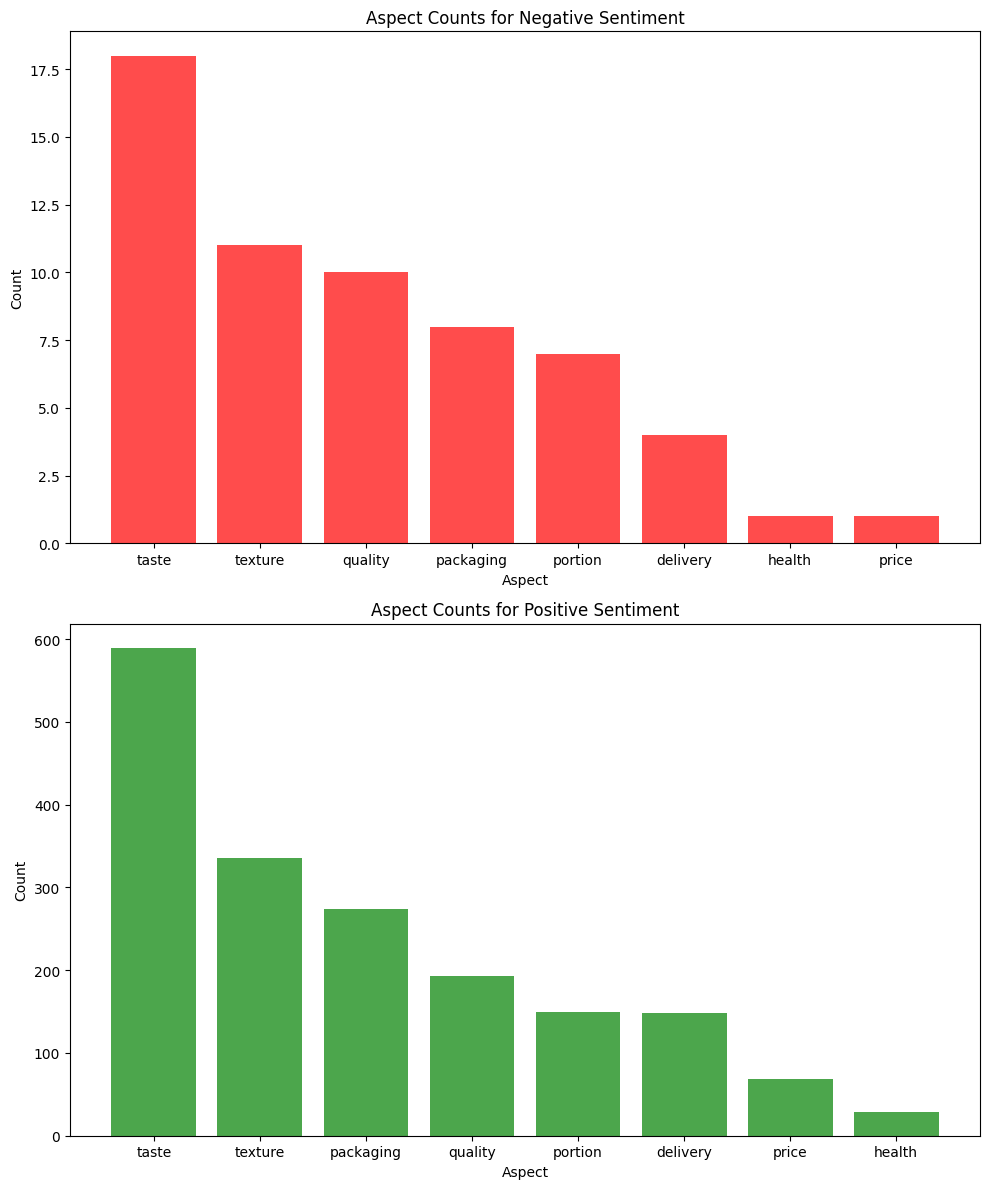

In [29]:
import matplotlib.pyplot as plt

# Filter the dataset based on predicted sentiment (assuming 0 for negative and 1 for positive)
neg = oatmeal_cookie[oatmeal_cookie['Predictions'] == -1 ]
pos = oatmeal_cookie[oatmeal_cookie['Predictions'] == 1 ]

# Function to extract aspects from the dataset
def extract_aspects(df):
    aspects = []
    for aspect_list in df['aspect']:
        aspects.extend(aspect_list)
    return aspects

# Extract aspects from negative sentiment subset
negative_aspects = extract_aspects(neg)
# Extract aspects from positive sentiment subset
positive_aspects = extract_aspects(pos)

# Count occurrences of each aspect for negative sentiment
negative_aspect_counts = pd.Series(negative_aspects).value_counts()
# Count occurrences of each aspect for positive sentiment
positive_aspect_counts = pd.Series(positive_aspects).value_counts()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot negative sentiment aspect counts
ax1.bar(negative_aspect_counts.index, negative_aspect_counts.values, color='red', alpha=0.7)
ax1.set_title('Aspect Counts for Negative Sentiment')
ax1.set_xlabel('Aspect')
ax1.set_ylabel('Count')


# Plot positive sentiment aspect counts
ax2.bar(positive_aspect_counts.index, positive_aspect_counts.values, color='green', alpha=0.7)
ax2.set_title('Aspect Counts for Positive Sentiment')
ax2.set_xlabel('Aspect')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()


## Top Product 2 - Energy Drink

In [32]:
energy_drink_aspect_terms = []

energy_drink = top_product_2.reset_index(drop=True)  # Resetting index

for i in range(len(energy_drink['Summary_Text'])):
    amod_pairs = []
    advmod_pairs = []
    compound_pairs = []
    xcomp_pairs = []
    neg_pairs = []
    # Assuming doc is defined somewhere
    doc = nlp(energy_drink.loc[i, 'Summary_Text'])
    for token in doc:
        if token.pos_ == 'NOUN':
            for j in token.lefts:
                if j.dep_ == 'compound':
                    compound_pairs.append((j.text+' '+token.text, token.text))
                if j.dep_ == 'amod' and j.pos_ == 'ADJ':   # primary condition
                    str1 = j.text+' '+token.text
                    amod_pairs.append(j.text+' '+token.text)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':  # secondary condition to get adjective of adjectives
                            str2 = k.text+' '+j.text+' '+token.text
                            amod_pairs.append(k.text+' '+j.text+' '+token.text)
                            mtch = re.search(re.escape(str1), re.escape(str2))
                            if mtch is not None:
                                amod_pairs.remove(str1)
        elif token.pos_ == 'VERB':
            for j in token.lefts:
                if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                    advmod_pairs.append(j.text+' '+token.text)
                if j.dep_ == 'neg' and j.pos_ == 'ADV':
                    neg_pairs.append(j.text+' '+token.text)
            for j in token.rights:
                if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                    advmod_pairs.append(token.text+' '+j.text)
        elif token.pos_ == 'ADJ':
            for j, h in zip(token.rights, token.lefts):
                for j, h in zip(token.rights, token.lefts):
                    if j.dep_ == 'xcomp' and h.dep_ != 'neg':
                        for k in j.lefts:
                            if k.dep_ == 'aux':
                                xcomp_pairs.append(token.text+' '+k.text+' '+j.text)
                    elif j.dep_ == 'xcomp' and h.dep_ == 'neg':
                        if k.dep_ == 'aux':
                            neg_pairs.append(h.text+' '+token.text+' '+k.text+' '+j.text)

    pairs = list(set(amod_pairs + advmod_pairs + neg_pairs + xcomp_pairs))
    for i in range(len(pairs)):
      if len(compound_pairs) != 0:
            for comp in compound_pairs:
              mtch = re.search(re.escape(comp[1]), re.escape(pairs[i]))
              if mtch is not None:
                  pairs[i] = pairs[i].replace(mtch.group(), comp[0])

    energy_drink_aspect_terms.append(pairs)


energy_drink['aspect_terms'] = energy_drink_aspect_terms


In [37]:
energy_drink_KPC = ['taste', 'packaging', 'price', 'delivery','quality','health']
energy_drink_clf = EmbeddingClassifier(nlp=nlp, classes=energy_drink_KPC, threshold=0.5)

In [38]:
energy_drink['aspect'] = energy_drink['aspect_terms'].apply(lambda x: energy_drink_clf.predict(x))

<ipython-input-10-a5f7cf08287d>:16: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  nlp(item)[:].similarity(class_item)


In [39]:
energy_drink

,ProductId,Summary_Text,Sentiment,Predictions,aspect_terms,aspect
0,B006MONQMC,Light and flavorful; helps me drink more water...,1,1,"[great product, more water, nice benefit, nice...","[taste, quality]"
1,B006MONQMC,Wasn't bad I am a really big fan of these sque...,0,1,"[less sugar, middle school, very mild fruit fr...",[taste]
2,B006MONQMC,Great vitamin/mineral additive I'm not a water...,1,-1,"[just say, good thinking, natural flavor, spar...","[taste, health, quality]"
3,B006MONQMC,"How much is a ""squeeze""? This vitamin/caffeine...",-1,1,"[rather strong syrup flavor, rather take, smal...",[taste]
4,B006MONQMC,So-so water additive I'm all for products that...,0,0,"[always looking, little sweetener, natural swe...","[taste, quality, packaging]"
...,...,...,...,...,...,...
486,B006MONQMC,"For active adults, better choice than Mio This...",1,1,"[colored beverage, old daughter, few vitamins,...","[quality, delivery, taste, health, packaging]"
487,B006MONQMC,Tastes good and works also with milk...I'm sol...,1,1,"[past week, right amount, still recommend, wor...","[taste, quality]"
488,B006MONQMC,Yuck!!! Qustionable benefits and tough to disp...,-1,-1,"[get easily, how big squeeze, generally mind, ...","[packaging, health, quality]"
489,B006MONQMC,It's got electrolytes Or so the bottle wrappin...,-1,0,"[daily requirements, bad tasting, vaguely frui...","[delivery, quality, taste, health, packaging]"


In [40]:
num_aspects_counts = energy_drink['aspect'].apply(len).value_counts().sort_index()

print("Number of Aspects Counts:")
print(num_aspects_counts)

Number of Aspects Counts:
aspect
0     33
1    123
2    175
3    113
4     38
5      9
Name: count, dtype: int64


In [49]:
exploded_df = energy_drink.explode('aspect')
aspect_sentiment_counts = exploded_df.groupby(['aspect', 'Predictions']).size().reset_index(name='Count')
pivoted_df = aspect_sentiment_counts.pivot(index='aspect', columns='Predictions', values='Count')

# Reset the index to make 'aspect' a column again
pivoted_df.reset_index(inplace=True)
pivoted_df

Predictions,aspect,-1,0,1
0,delivery,3,16,23
1,health,13,13,24
2,packaging,37,98,147
3,price,1,6,14
4,quality,41,83,128
5,taste,57,123,182


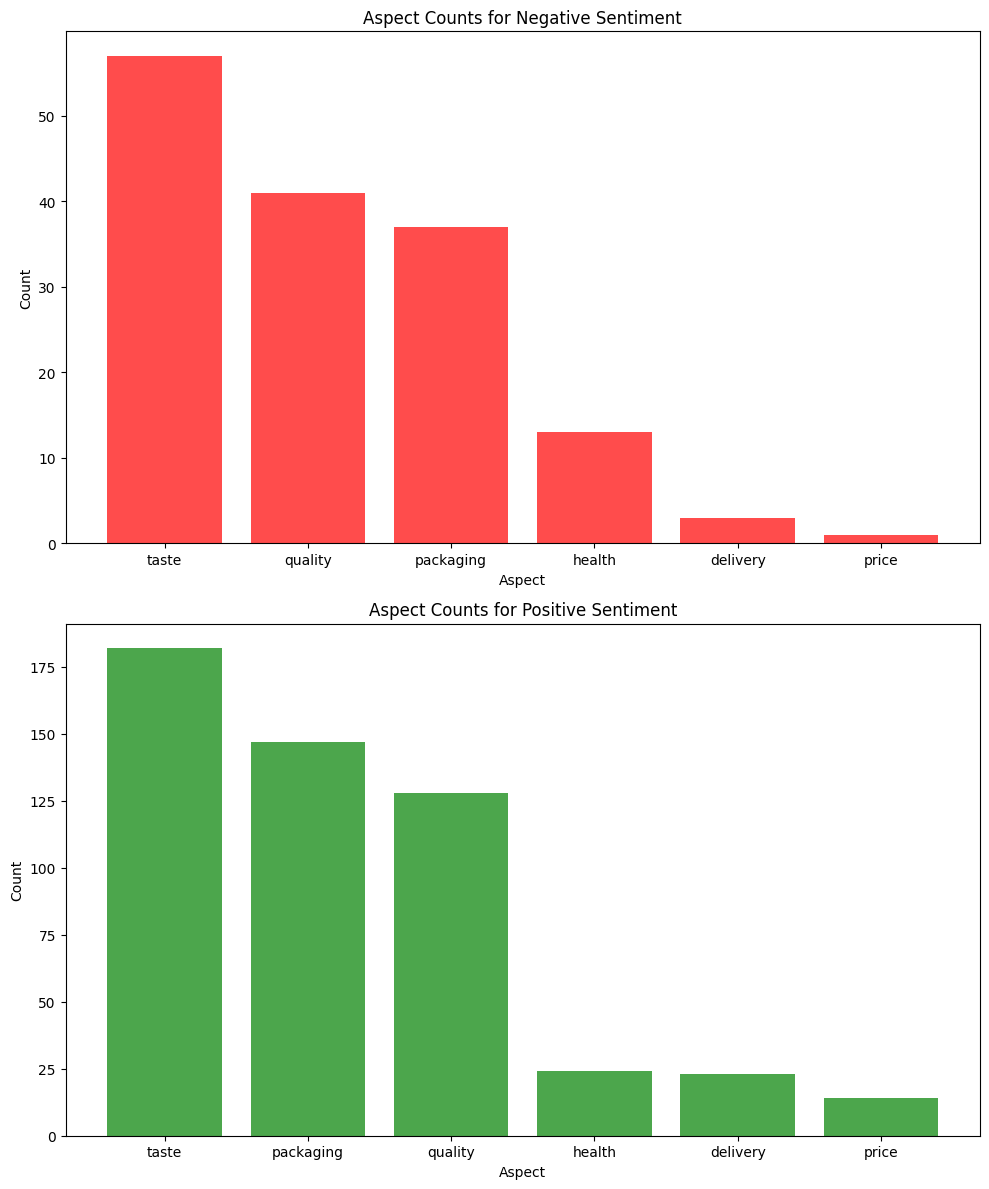

In [41]:
import matplotlib.pyplot as plt

# Filter the dataset based on predicted sentiment (assuming 0 for negative and 1 for positive)
neg = energy_drink[energy_drink['Predictions'] == -1 ]
pos = energy_drink[energy_drink['Predictions'] == 1 ]

# Function to extract aspects from the dataset
def extract_aspects(df):
    aspects = []
    for aspect_list in df['aspect']:
        aspects.extend(aspect_list)
    return aspects

# Extract aspects from negative sentiment subset
negative_aspects = extract_aspects(neg)
# Extract aspects from positive sentiment subset
positive_aspects = extract_aspects(pos)

# Count occurrences of each aspect for negative sentiment
negative_aspect_counts = pd.Series(negative_aspects).value_counts()
# Count occurrences of each aspect for positive sentiment
positive_aspect_counts = pd.Series(positive_aspects).value_counts()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot negative sentiment aspect counts
ax1.bar(negative_aspect_counts.index, negative_aspect_counts.values, color='red', alpha=0.7)
ax1.set_title('Aspect Counts for Negative Sentiment')
ax1.set_xlabel('Aspect')
ax1.set_ylabel('Count')


# Plot positive sentiment aspect counts
ax2.bar(positive_aspect_counts.index, positive_aspect_counts.values, color='green', alpha=0.7)
ax2.set_title('Aspect Counts for Positive Sentiment')
ax2.set_xlabel('Aspect')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()
